<a href="https://colab.research.google.com/github/surajmalaka29/Big-Data-Analytics-Project/blob/main/Ecommerce_Consumer_Behavior.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1.1: Install Java (required for Spark)
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Step 1.2: Install PySpark
!pip install pyspark

# Step 1.3: Install findspark to locate Spark
!pip install findspark

# Step 1.4: Install visualization libraries
!pip install matplotlib seaborn plotly


In [2]:
# Import necessary libraries
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import ClusteringEvaluator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create Spark Session
spark = SparkSession.builder \
    .appName("EcommerceCustomerAnalytics") \
    .master("local[*]") \
    .getOrCreate()

print("PySpark Version:", spark.version)


PySpark Version: 3.5.1


In [4]:
# Upload your CSV file to Google Colab first
from google.colab import files
uploaded = files.upload()

# Load data into PySpark DataFrame
df = spark.read.csv("Ecommerce_Consumer_Behavior_Analysis_Data.csv",
                    header=True, inferSchema=True)

# Basic exploration
print("Dataset shape:", df.count(), "rows,", len(df.columns), "columns")
df.printSchema()
df.show(5)

# Check for missing values
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()


Saving Ecommerce_Consumer_Behavior_Analysis_Data.csv to Ecommerce_Consumer_Behavior_Analysis_Data.csv
Dataset shape: 1000 rows, 28 columns
root
 |-- Customer_ID: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Income_Level: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Education_Level: string (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Purchase_Category: string (nullable = true)
 |-- Purchase_Amount: string (nullable = true)
 |-- Frequency_of_Purchase: integer (nullable = true)
 |-- Purchase_Channel: string (nullable = true)
 |-- Brand_Loyalty: integer (nullable = true)
 |-- Product_Rating: integer (nullable = true)
 |-- Time_Spent_on_Product_Research(hours): double (nullable = true)
 |-- Social_Media_Influence: string (nullable = true)
 |-- Discount_Sensitivity: string (nullable = true)
 |-- Return_Rate: integer (nullable = true)
 |-- Custo

In [5]:
# Clean Purchase_Amount (remove $ sign and convert to numeric)
df = df.withColumn("Purchase_Amount",
                   regexp_replace(col("Purchase_Amount"), "\\$", "").cast("double"))

# Handle missing values
df = df.fillna({
    "Social_Media_Influence": "None",
    "Engagement_with_Ads": "None"
})

# Create numerical encoding for categorical variables
from pyspark.ml.feature import StringIndexer, OneHotEncoder

categorical_cols = ["Gender", "Income_Level", "Marital_Status",
                   "Education_Level", "Purchase_Category", "Purchase_Channel"]

# Apply StringIndexer and OneHotEncoder
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=col+"_index", outputCol=col+"_encoded") for col in categorical_cols]

# Display cleaned data summary
df.describe().show()


+-------+-----------+-----------------+----------+------------+--------------+---------------+----------+--------------------+--------------------+------------------+---------------------+----------------+------------------+------------------+-------------------------------------+----------------------+--------------------+------------------+---------------------+-------------------+------------------------+--------------+----------------+---------------+-------------------+-----------------+
|summary|Customer_ID|              Age|    Gender|Income_Level|Marital_Status|Education_Level|Occupation|            Location|   Purchase_Category|   Purchase_Amount|Frequency_of_Purchase|Purchase_Channel|     Brand_Loyalty|    Product_Rating|Time_Spent_on_Product_Research(hours)|Social_Media_Influence|Discount_Sensitivity|       Return_Rate|Customer_Satisfaction|Engagement_with_Ads|Device_Used_for_Shopping|Payment_Method|Time_of_Purchase|Purchase_Intent|Shipping_Preference| Time_to_Decision|
+---

In [6]:
# Select features for customer segmentation
feature_cols = [
    "Age",
    "Purchase_Amount",
    "Frequency_of_Purchase",
    "Brand_Loyalty",
    "Product_Rating",
    "Time_Spent_on_Product_Research(hours)",
    "Return_Rate",
    "Customer_Satisfaction",
    "Time_to_Decision"
]

# Create feature vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_raw")
df_assembled = assembler.transform(df)

# Scale the features
scaler = StandardScaler(inputCol="features_raw", outputCol="features")
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

df_scaled.select("features").show(5, truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                   |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[2.3521265307028845,2.5377662257885483,1.2709060312486116,3.529071624314018,3.4803088885502453,2.5258826607597453,1.2341536324702185,2.4403391383684148,0.4955586498935283]|
|[5.238827272929151,1.6894619853047668,3.4949915859336818,2.117442974588411,0.6960617777100491,2.5258826607597453,1.2341536324702185,1.7430993845488676,1.486675949680585]  |
|[2.5659562153122373,3.240403597230662,0.6354530156243058,3.529071624314018,3.4803088885502453,0.37888239911396177,1.2341536324702

In [7]:
# Test different numbers of clusters
costs = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(featuresCol="features", predictionCol="cluster", k=k, seed=42)
    model = kmeans.fit(df_scaled)
    predictions = model.transform(df_scaled)

    evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="cluster")
    silhouette = evaluator.evaluate(predictions)
    cost = model.summary.trainingCost
    costs.append(cost)
    print(f"k={k}, Cost={cost:.2f}, Silhouette={silhouette:.3f}")

# Convert to Pandas for plotting
cost_df = pd.DataFrame({'k': list(K_range), 'cost': costs})


k=2, Cost=8204.62, Silhouette=0.155
k=3, Cost=7715.51, Silhouette=0.139
k=4, Cost=7285.81, Silhouette=0.152
k=5, Cost=6991.29, Silhouette=0.145
k=6, Cost=6729.65, Silhouette=0.147
k=7, Cost=6554.60, Silhouette=0.144
k=8, Cost=6300.19, Silhouette=0.151
k=9, Cost=6113.22, Silhouette=0.148
k=10, Cost=5962.06, Silhouette=0.152


In [8]:
# Based on elbow method, choose optimal k (let's say k=4)
optimal_k = 4

# Train final model
kmeans = KMeans(featuresCol="features", predictionCol="cluster", k=optimal_k, seed=42)
model = kmeans.fit(df_scaled)
predictions = model.transform(df_scaled)

# Show cluster centers
centers = model.clusterCenters()
print("Cluster Centers:")
for i, center in enumerate(centers):
    print(f"Cluster {i}: {center}")

# Add cluster labels to original data
results = predictions.select("Customer_ID", "cluster", *feature_cols)
results.show(10)


Cluster Centers:
Cluster 0: [3.53312433 1.93489352 1.59474266 1.89755467 2.53527117 0.75669616
 1.88445766 2.35452501 1.96317465]
Cluster 1: [3.86153811 2.08446318 1.34452559 2.19204124 1.98349311 1.60896672
 0.52677289 1.42140543 1.50480614]
Cluster 2: [3.99409513 1.77686872 2.89182785 2.80604232 1.86748282 1.65979241
 1.73082522 1.66940738 1.86841727]
Cluster 3: [3.29237359 2.57361213 3.02352645 1.66492492 2.03485802 1.12315206
 0.53247758 2.0551704  2.13609757]
+-----------+-------+---+---------------+---------------------+-------------+--------------+-------------------------------------+-----------+---------------------+----------------+
|Customer_ID|cluster|Age|Purchase_Amount|Frequency_of_Purchase|Brand_Loyalty|Product_Rating|Time_Spent_on_Product_Research(hours)|Return_Rate|Customer_Satisfaction|Time_to_Decision|
+-----------+-------+---+---------------+---------------------+-------------+--------------+-------------------------------------+-----------+---------------------+---

In [9]:
# Convert to Pandas for easier analysis
results_pd = results.toPandas()

# Analyze each cluster
cluster_analysis = results_pd.groupby('cluster').agg({
    'Age': 'mean',
    'Purchase_Amount': 'mean',
    'Frequency_of_Purchase': 'mean',
    'Brand_Loyalty': 'mean',
    'Customer_Satisfaction': 'mean',
    'Time_to_Decision': 'mean'
}).round(2)

print("Cluster Analysis:")
print(cluster_analysis)

# Count customers in each cluster
cluster_counts = results_pd['cluster'].value_counts().sort_index()
print("\nCustomers per cluster:")
print(cluster_counts)


Cluster Analysis:
           Age  Purchase_Amount  Frequency_of_Purchase  Brand_Loyalty  \
cluster                                                                 
0        33.15           255.70                   5.00           2.69   
1        36.03           273.41                   4.27           3.09   
2        37.33           233.58                   9.07           3.96   
3        30.81           337.66                   9.53           2.39   

         Customer_Satisfaction  Time_to_Decision  
cluster                                           
0                         6.76              7.96  
1                         4.04              6.02  
2                         4.79              7.52  
3                         5.92              8.66  

Customers per cluster:
cluster
0    259
1    247
2    245
3    249
Name: count, dtype: int64


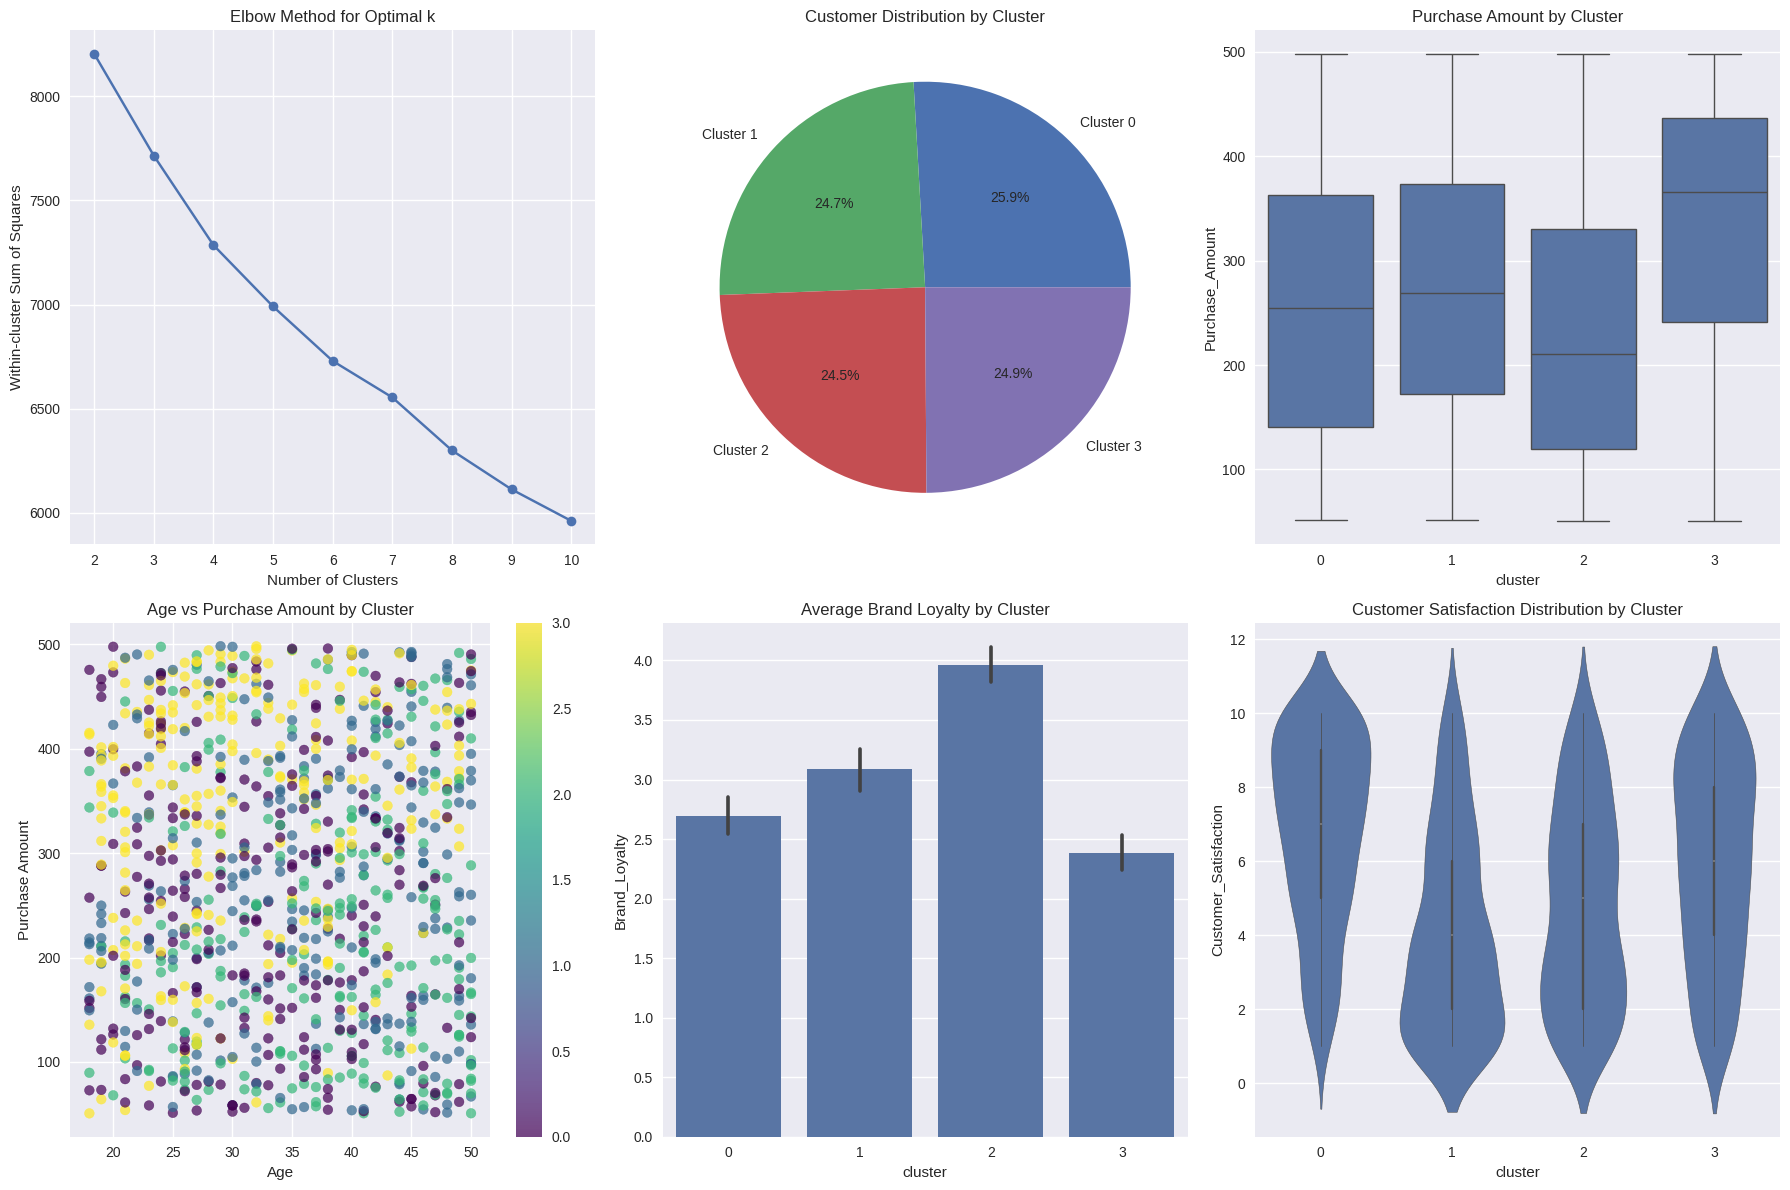

In [10]:
# Set up plotting style
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Elbow Curve
axes[0,0].plot(cost_df['k'], cost_df['cost'], marker='o')
axes[0,0].set_title('Elbow Method for Optimal k')
axes[0,0].set_xlabel('Number of Clusters')
axes[0,0].set_ylabel('Within-cluster Sum of Squares')

# 2. Cluster Distribution
axes[0,1].pie(cluster_counts.values, labels=[f'Cluster {i}' for i in cluster_counts.index],
              autopct='%1.1f%%')
axes[0,1].set_title('Customer Distribution by Cluster')

# 3. Purchase Amount by Cluster
sns.boxplot(data=results_pd, x='cluster', y='Purchase_Amount', ax=axes[0,2])
axes[0,2].set_title('Purchase Amount by Cluster')

# 4. Age vs Purchase Amount (colored by cluster)
scatter = axes[1,0].scatter(results_pd['Age'], results_pd['Purchase_Amount'],
                           c=results_pd['cluster'], cmap='viridis', alpha=0.7)
axes[1,0].set_xlabel('Age')
axes[1,0].set_ylabel('Purchase Amount')
axes[1,0].set_title('Age vs Purchase Amount by Cluster')
plt.colorbar(scatter, ax=axes[1,0])

# 5. Brand Loyalty by Cluster
sns.barplot(data=results_pd, x='cluster', y='Brand_Loyalty', ax=axes[1,1])
axes[1,1].set_title('Average Brand Loyalty by Cluster')

# 6. Customer Satisfaction by Cluster
sns.violinplot(data=results_pd, x='cluster', y='Customer_Satisfaction', ax=axes[1,2])
axes[1,2].set_title('Customer Satisfaction Distribution by Cluster')

plt.tight_layout()
plt.show()


In [11]:
# Create detailed segment profiles
segment_profiles = results_pd.groupby('cluster').agg({
    'Age': ['mean', 'std'],
    'Purchase_Amount': ['mean', 'std'],
    'Frequency_of_Purchase': ['mean', 'std'],
    'Brand_Loyalty': ['mean', 'std'],
    'Customer_Satisfaction': ['mean', 'std']
}).round(2)

print("Detailed Segment Profiles:")
print(segment_profiles)

# Customer segment labels based on analysis
segment_labels = {
    0: "Budget-Conscious Shoppers",
    1: "Premium Customers",
    2: "Occasional Buyers",
    3: "Loyal Enthusiasts"
}

results_pd['Segment_Name'] = results_pd['cluster'].map(segment_labels)

# Final summary table
summary_table = results_pd.groupby(['cluster', 'Segment_Name']).size().reset_index(name='Count')
summary_table['Percentage'] = (summary_table['Count'] / len(results_pd) * 100).round(1)
print("\nFinal Customer Segments:")
print(summary_table)


Detailed Segment Profiles:
           Age       Purchase_Amount         Frequency_of_Purchase        \
          mean   std            mean     std                  mean   std   
cluster                                                                    
0        33.15  8.99          255.70  131.30                  5.00  2.35   
1        36.03  9.43          273.41  125.07                  4.27  1.84   
2        37.33  8.87          233.58  129.37                  9.07  2.12   
3        30.81  8.77          337.66  117.25                  9.53  2.03   

        Brand_Loyalty       Customer_Satisfaction        
                 mean   std                  mean   std  
cluster                                                  
0                2.69  1.32                  6.76  2.57  
1                3.09  1.37                  4.04  2.67  
2                3.96  1.21                  4.79  2.72  
3                2.39  1.27                  5.92  2.74  

Final Customer Segments:
   clust

In [12]:
# Marketing recommendations for each segment
recommendations = {
    "Budget-Conscious Shoppers": [
        "Focus on discount campaigns and value propositions",
        "Promote bulk buying offers",
        "Target with cost-saving messaging"
    ],
    "Premium Customers": [
        "Offer premium products and exclusive services",
        "Implement VIP loyalty programs",
        "Focus on quality and luxury positioning"
    ],
    "Occasional Buyers": [
        "Re-engagement campaigns with personalized offers",
        "Email marketing with product recommendations",
        "Limited-time promotions to increase frequency"
    ],
    "Loyal Enthusiasts": [
        "Reward loyalty with exclusive previews",
        "Referral programs and advocacy opportunities",
        "Premium customer service and support"
    ]
}

for segment, recs in recommendations.items():
    print(f"\n{segment}:")
    for i, rec in enumerate(recs, 1):
        print(f"  {i}. {rec}")



Budget-Conscious Shoppers:
  1. Focus on discount campaigns and value propositions
  2. Promote bulk buying offers
  3. Target with cost-saving messaging

Premium Customers:
  1. Offer premium products and exclusive services
  2. Implement VIP loyalty programs
  3. Focus on quality and luxury positioning

Occasional Buyers:
  1. Re-engagement campaigns with personalized offers
  2. Email marketing with product recommendations
  3. Limited-time promotions to increase frequency

Loyal Enthusiasts:
  1. Reward loyalty with exclusive previews
  2. Referral programs and advocacy opportunities
  3. Premium customer service and support
